# 任务2: 最简单的线性回归

## 大纲
- 任务描述
- 生成数据
- Keras
- Estimator
- Low Level API

## 任务描述
给定一组x和y的样本，他们大体符合y=wx+b。目标是根据给定的x和y样本，求解出w和b。即线性回归。
更多详情请参考[wikipedia](https://zh.wikipedia.org/wiki/%E7%B7%9A%E6%80%A7%E5%9B%9E%E6%AD%B8)。

## 生成数据
通过程序，生成一组x和y，符合y=wx+b+noise。

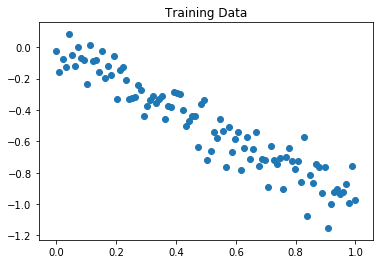

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def generate_data(w, b, num_sample=100, noise_sigma=0.1):
    noise = np.random.randn(num_sample) * noise_sigma
    x = np.linspace(0, 1, num_sample)
    np.random.shuffle(x)
    y = w * (x + noise) + b
    return x, y

x_train, y_train = generate_data(w=-1, b=0)
plt.scatter(x_train, y_train)
plt.title('Training Data')
plt.show()

# 回到Slides看loss和optimizer概念

# Keras
### 定义模型
使用Keras来快速求解。
- loss 损失函数为mse，即最小均方误差
- optimizer 优化器为sgd，即随机梯度下降

In [2]:
import tensorflow as tf

def linear_regression_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(
        input_dim=1,
        units=1,
        name='dense'))
    model.compile(loss='mse', optimizer='sgd')
    return model

model = linear_regression_model();

### 训练 (training)

每一小批数据为batch_size个样本，对所有数据进行epochs次遍历。

In [3]:
model.fit(x_train,
          y_train,
          batch_size=50, 
          epochs=1000,
          verbose=0)
print("Done")

Done


### 推断 (inference)
用Keras训练出来的模型，进行推理(inference)。推断结果和训练样本放一起展现出来。
效果不好的话，调整哪些参数改进。

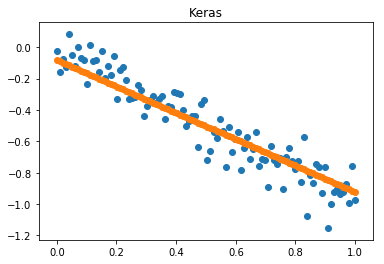

In [4]:
x_test = np.linspace(0, 1, 100)
np.random.shuffle(x_test)
y_test_keras = model.predict(x_test)
plt.title("Keras")
plt.scatter(x_train, y_train)
plt.scatter(x_test, y_test_keras)
plt.show()

### 查看Keras模型描述
- 看有几层
- 看每层的输入输出情况
- 看有几个参数

In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


## Canned Estimator (开箱即用的模型)

因为都封装好了，开箱即用，所以我们不需要定义模型了。
### 训练

In [6]:
# define the feature, here it's x
feature_columns = [
    tf.feature_column.numeric_column("x", shape=[1])]
# define input function
input_fn_train = tf.estimator.inputs.numpy_input_fn(
    {"x": x_train}, y_train, batch_size=50, num_epochs=100, shuffle=False)

estimator = tf.estimator.LinearRegressor(
    feature_columns=feature_columns,
    model_dir='/notebooks/logs/estimator')
estimator = estimator.train(input_fn=input_fn_train)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f542d214a10>, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/notebooks/tflab/logs/estimator', '_save_summary_steps': 100}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /notebooks/tflab/logs/estimator/model.ckpt.
INFO:tensorflow:loss = 17.4802, step = 1
INFO:tensorflow:global_step/sec: 780.099
INFO:tensorflow:loss = 0.528095, step = 101 (0.129 sec)
INFO:tensorflow:Saving checkpoints for 200 into /notebooks/tflab/logs/estimator/model.ckpt.
INFO:tensorflow:Loss for final step: 0.404

### 推断

INFO:tensorflow:Restoring parameters from /notebooks/tflab/logs/estimator/model.ckpt-200


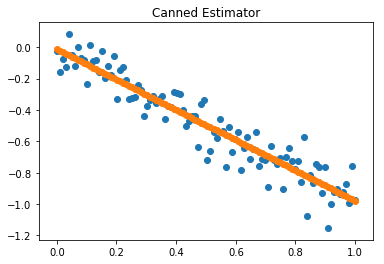

In [7]:
input_fn_test = tf.estimator.inputs.numpy_input_fn(
    {"x": x_test}, batch_size=50, shuffle=False)
y_test_generator = estimator.predict(
    input_fn=input_fn_test)
# get data from generator as conver to numpy array
y_test_estimator = np.array(
    [p["predictions"][0] for p in list(y_test_generator)])
plt.scatter(x_train, y_train)
plt.scatter(x_test, y_test_estimator)
plt.title("Canned Estimator")
plt.show()

### 演示TensorBoard

```
docker exec -it tflab bash
tensorboard --logdir=/notebooks/logs
```

## TensorFlow Low Level API
使用TensorFlow低层级API来实现线性回归

In [8]:
llapi_logdir = '/notebooks/logs/llapi'
graph = tf.Graph()
with graph.as_default():
    # define the input layer (scope)
    with tf.name_scope('input'):
        input_data = tf.placeholder(tf.float32, shape=(None, 1), name="input_data")

    # define model's core part, y=wx+b
    with tf.name_scope('model'):
        W = tf.Variable(tf.truncated_normal([1,1], stddev=0.1), name="W")
        b = tf.Variable(tf.constant(0.1, shape=[1]), name="b")
        output_data = tf.add(input_data * W, b, name="output_data")

    # define the loss (MSE); use GD as optimizer
    with tf.name_scope('train'):
        target_op = tf.placeholder(tf.float32, shape=(None, 1), name="target_op")
        loss = tf.reduce_mean(tf.square(output_data - target_op), name="loss")
        optimizer = tf.train.GradientDescentOptimizer(0.5)
        train_op = optimizer.minimize(loss, name="train_op")

    # log loss for TensorBoard
    tf.summary.scalar('loss', loss)
    summary_op = tf.summary.merge_all()

### 训练

In [9]:
# Init
session = tf.InteractiveSession(graph=graph)
session.run(tf.global_variables_initializer())

# Train
event_writer = tf.summary.FileWriter(llapi_logdir, session.graph)
for step in range(100):
    summary, _ = session.run([summary_op, train_op],
                             feed_dict={
                                 input_data: x_train.reshape(-1, 1),
                                 target_op: y_train.reshape(-1, 1)})
    # log
    event_writer.add_summary(summary, step)
event_writer.close()

### 推断

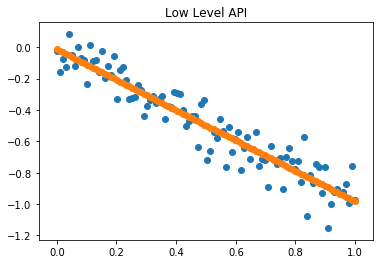

In [10]:
# Inference
y_test_llapi = session.run(output_data,
                           feed_dict={
                               input_data: x_test.reshape(-1, 1)})
plt.scatter(x_train, y_train)
plt.scatter(x_test, y_test_llapi)
plt.title("Low Level API")
plt.show()

### 备份模型
模型的结构描述在[GraphDef](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/core/framework/graph.proto)

In [11]:
# backup graph and weight
import os

tf.train.write_graph(session.graph.as_graph_def(),
                     llapi_logdir,
                     'model.pb',
                     False)
saver = tf.train.Saver(tf.trainable_variables())
saver.save(session,
           os.path.join(llapi_logdir, 'weights'))

'/notebooks/logs/llapi/weights'